In [ ]:
# Date    :   2024-12-22
# Author  :   Dongwoo Yoon
# Contact :   dbsehddn0901@gmail.com

# 1 . Download dataset
구글 이미지와 유튜브 동영상에서 캡처한 이미지를 활용하여 roboflow에서 어노테이션 작업을 완료했습니다.

작업이 끝난 데이터셋은 Roboflow의 API를 사용하여 다운로드했습니다.

In [ ]:
!pip install roboflow

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="▒▒▒▒▒▒▒▒▒▒")
project = rf.workspace("dongwoo-k0nzb").project("hornet-detection-dikcl")
version = project.version(1)
dataset = version.download("yolov8")

In [ ]:
# data.yaml 내에 train, val, test dataset 상대경로를 절대경로로 수정
!sed -i 's|\.\./|/content/Hornet-Detection-1/|g' ./Hornet-Detection-1/data.yaml

# 2 . Random images

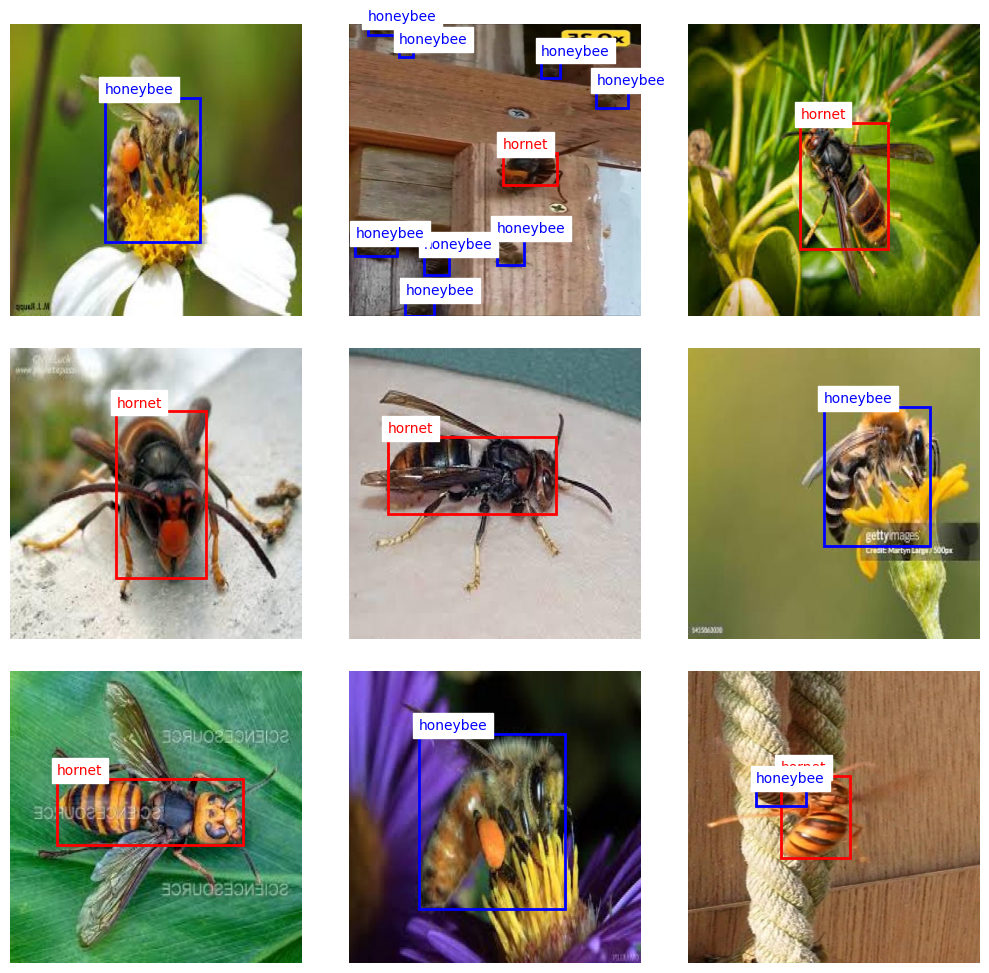

In [80]:
import os
import random
import matplotlib.pyplot as plt

# 이미지 및 라벨 폴더 경로
image_folder = 'Hornet-Detection-1/train/images'
label_folder = 'Hornet-Detection-1/train/labels'

# 클래스 이름 리스트 (예: YOLOv8 `data.yaml` 파일에서 가져옴)
class_names = ['honeybee', 'hornet']  # 클래스 이름

# 클래스별 색상 지정
class_colors = {
    'honeybee': 'blue',
    'hornet': 'red'
}

# 폴더 내의 모든 .jpg 파일 리스트 가져오기
image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg')]

# 랜덤으로 9개의 이미지 선택
random_images = random.sample(image_files, 9)

# 3x3 그리드로 이미지 표시
fig, axes = plt.subplots(3, 3, figsize=(10, 10))  # 3x3 그리드, 크기 설정

for ax, img_file in zip(axes.flat, random_images):
    # 이미지 경로 및 로드
    img_path = os.path.join(image_folder, img_file)
    img = plt.imread(img_path)

    # 이미지 파일에 대응되는 라벨 파일 경로
    label_file = os.path.join(label_folder, img_file.replace('.jpg', '.txt'))

    # 이미지 출력
    ax.imshow(img)
    ax.axis('off')  # 축 숨기기

    # 라벨 파일이 존재하는 경우 바운딩 박스 그리기
    if os.path.exists(label_file):
        with open(label_file, 'r') as f:
            for line in f:
                # YOLOv8 형식 라벨 파싱
                class_id, x_center, y_center, width, height = map(float, line.strip().split())
                class_name = class_names[int(class_id)]
                box_color = class_colors[class_name]  # 클래스에 맞는 색상

                # 바운딩 박스 좌표 변환 (YOLO 형식 -> 픽셀 좌표)
                img_h, img_w = img.shape[:2]
                x_center *= img_w
                y_center *= img_h
                width *= img_w
                height *= img_h

                # 바운딩 박스 좌상단 (x1, y1) 및 우하단 (x2, y2) 계산
                x1 = int(x_center - width / 2)
                y1 = int(y_center - height / 2)
                x2 = int(x_center + width / 2)
                y2 = int(y_center + height / 2)

                # 바운딩 박스 및 레이블 그리기
                ax.add_patch(plt.Rectangle((x1, y1), width, height, edgecolor=box_color, facecolor='none', linewidth=2))
                ax.text(x1, y1 - 10, class_name, color=box_color, fontsize=10, backgroundcolor='white')

plt.tight_layout()
plt.show()


# 3 . Load a pre-trained model (YOLO)

In [ ]:
!pip3 install ultralytics

In [ ]:
import ultralytics
from ultralytics import YOLO
ultralytics.checks()

Ultralytics 8.3.53 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.7/235.7 GB disk)


In [ ]:
model = YOLO('yolov8n.pt') #yolov8n(나노), yolov8s(스몰), yolov8m(미디움), yolov8l(라지), yolov8x(엑스트라) 등이 있음

# 4 . Model training

In [ ]:
project = "runs/detect"
train_name = "train"
dataset_path = "Hornet-Detection-1/data.yaml"

In [ ]:
model.train(
    data=dataset_path,  # 데이터셋 경로, 일반적으로 YAML 파일 경로를 지정
    epochs=200,         # 학습 반복 횟수, 최대 200 에포크까지 학습
    project=project,    # 프로젝트 결과를 저장할 폴더 이름 (예: 'runs')
    name=train_name,    # 실험 결과를 저장할 하위 폴더 이름 (예: 'train')
    exist_ok=False,     # 동일한 폴더가 이미 있을 경우 덮어쓰지 않고 에러를 발생시킴
    seed=42,            # 재현성을 위한 랜덤 시드 설정 (결과가 동일하도록 고정)
    optimizer='AdamW',  # AdamW 옵티마이저 사용 (L2 정규화를 포함한 Adam 개선 버전)
    # patience=5,       # 5번의 에포크 동안 검증 손실이 개선되지 않으면 조기 종료
    batch=32,           # 배치 크기 설정, 한 번에 32개의 이미지를 처리
    imgsz=640,          # 입력 이미지 크기, 모델의 입력 크기를 640x640로 고정
    degrees=0.15,       # 데이터 증강: 이미지 회전 범위 설정 (-15° ~ +15°)
    fliplr=0.5          # 데이터 증강: 50% 확률로 이미지 좌우 반전 적용
)


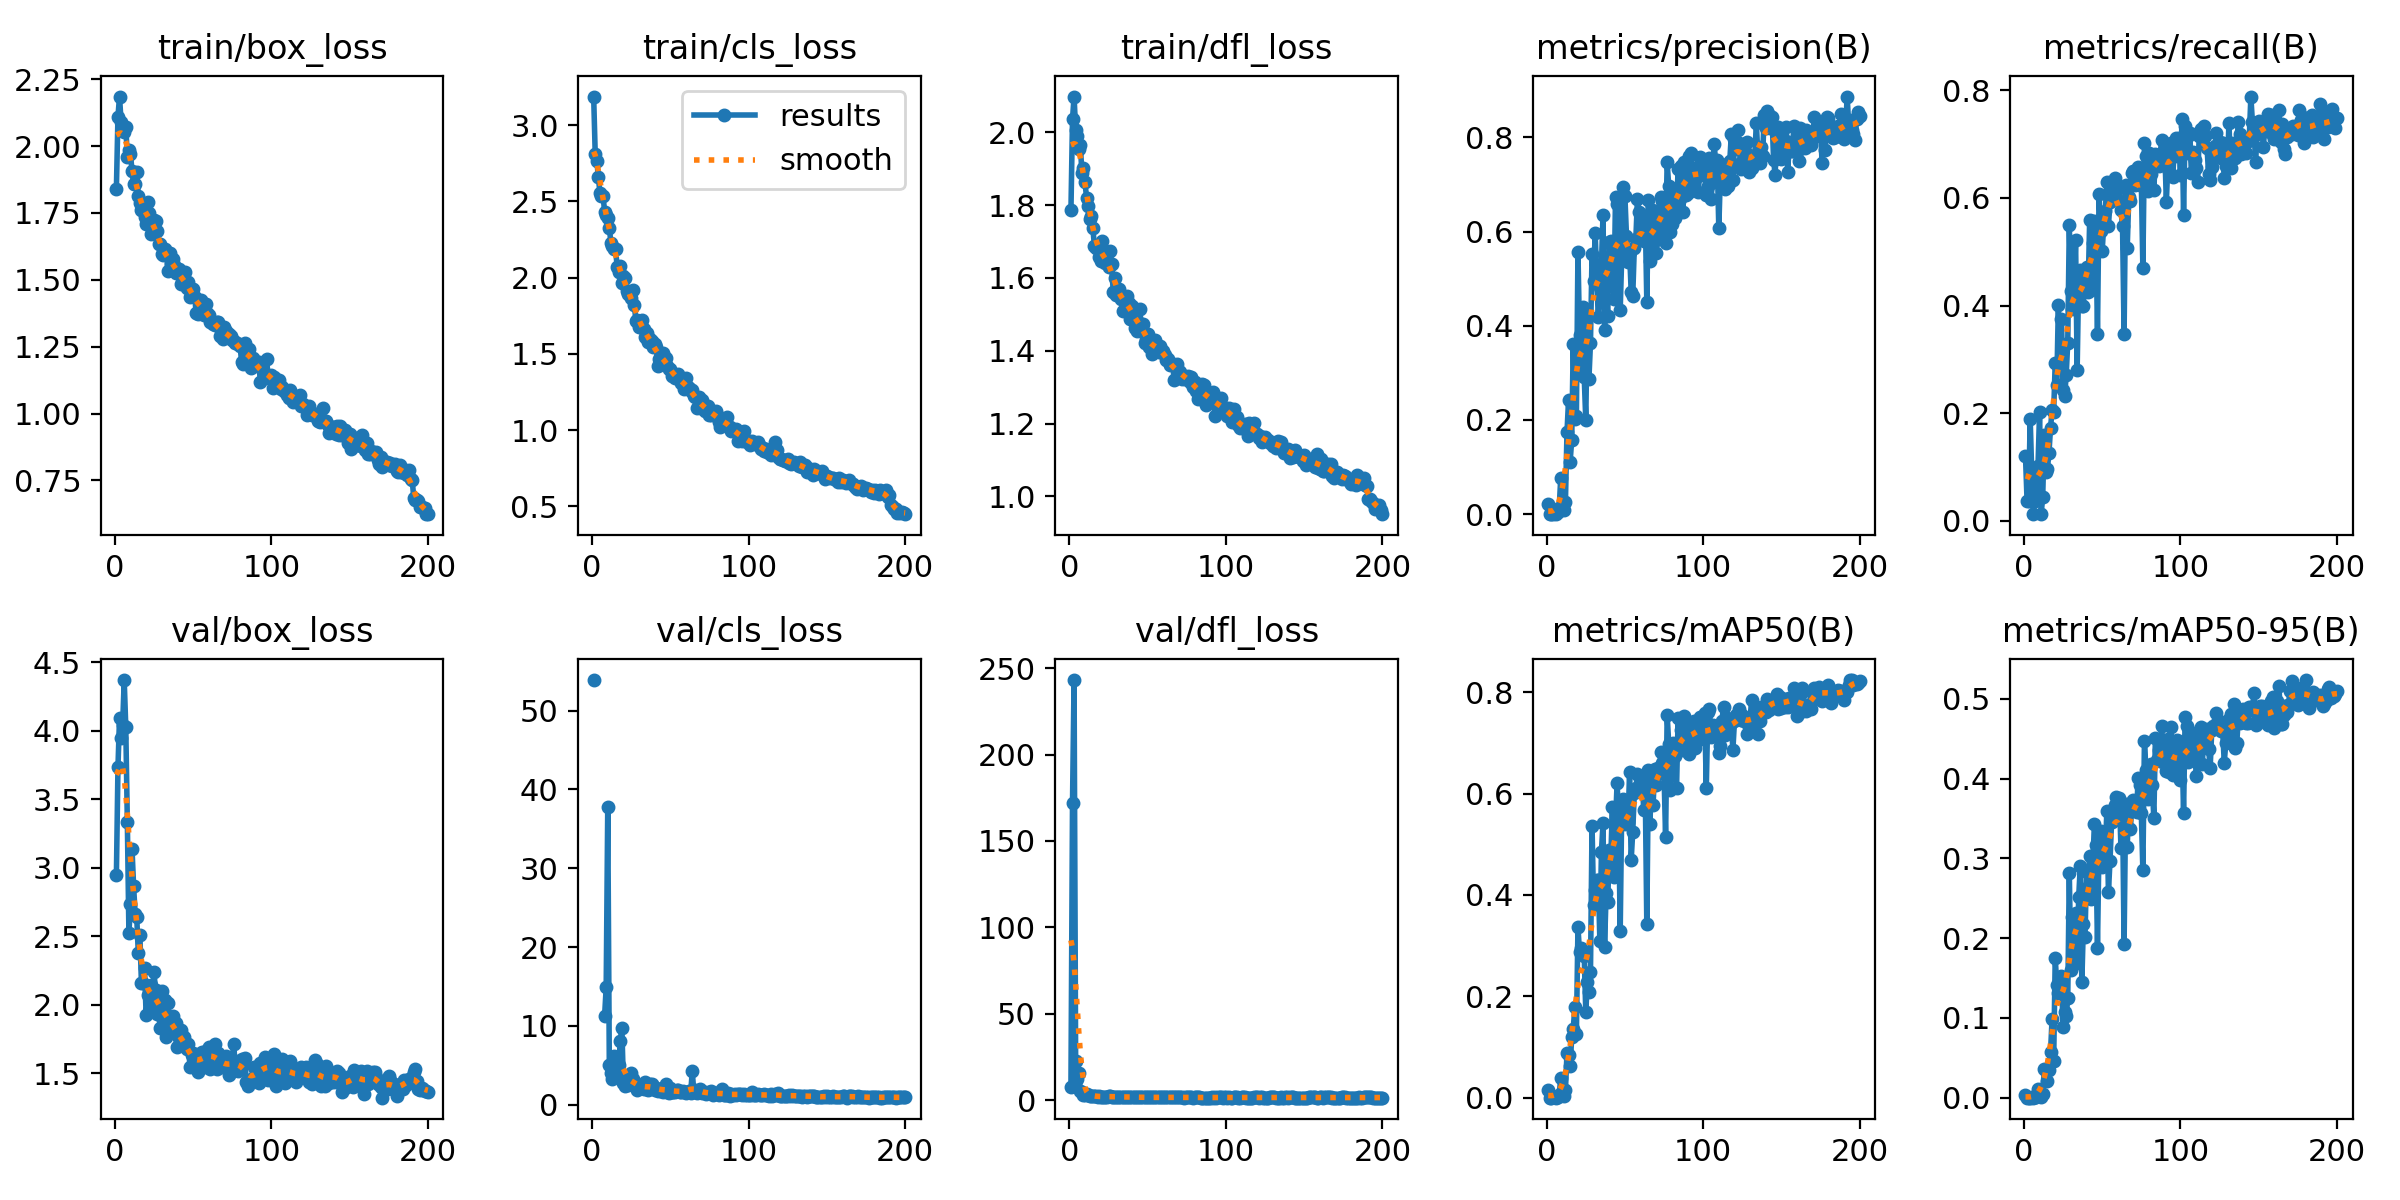

In [ ]:
from IPython.display import Image as show_image
show_image(f"{project}/{train_name}/results.png", width=800)

사용 가능한 컬럼:
Index(['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss',
       'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)',
       'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss',
       'lr/pg0', 'lr/pg1', 'lr/pg2'],
      dtype='object')


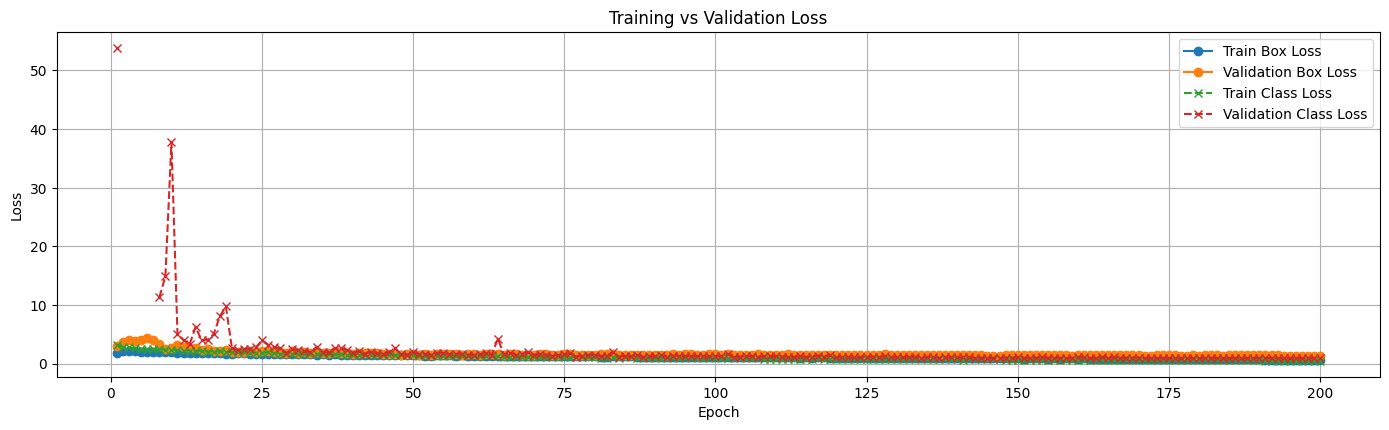

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# CSV 파일 경로
results_csv = f'{project}/{train_name}/results.csv'
results_df = pd.read_csv(results_csv)

# 컬럼 출력 및 확인
print("사용 가능한 컬럼:")
print(results_df.columns)

# 그래프 그리기
plt.figure(figsize=(14, 8))

# (1) 손실 그래프: Train Loss vs Validation Loss
plt.subplot(2, 1, 1)
plt.plot(results_df['epoch'], results_df['train/box_loss'], label='Train Box Loss', marker='o')
plt.plot(results_df['epoch'], results_df['val/box_loss'], label='Validation Box Loss', marker='o')
plt.plot(results_df['epoch'], results_df['train/cls_loss'], label='Train Class Loss', linestyle='--', marker='x')
plt.plot(results_df['epoch'], results_df['val/cls_loss'], label='Validation Class Loss', linestyle='--', marker='x')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# (2) 정확도 그래프: Precision, Recall, mAP
if 'metrics/mAP_50' in results_df.columns:
    plt.subplot(2, 1, 2)
    if 'metrics/precision' in results_df.columns:
        plt.plot(results_df['epoch'], results_df['metrics/precision'], label='Precision', marker='o')
    if 'metrics/recall' in results_df.columns:
        plt.plot(results_df['epoch'], results_df['metrics/recall'], label='Recall', marker='o')
    if 'metrics/mAP_50' in results_df.columns:
        plt.plot(results_df['epoch'], results_df['metrics/mAP_50'], label='mAP@50', linestyle='--', marker='x')
    if 'metrics/mAP_50-95' in results_df.columns:
        plt.plot(results_df['epoch'], results_df['metrics/mAP_50-95'], label='mAP@50-95', linestyle='--', marker='x')
    plt.title('Precision, Recall, and mAP')
    plt.xlabel('Epoch')
    plt.ylabel('Metrics')
    plt.legend()
    plt.grid(True)

# 그래프 출력
plt.tight_layout()
plt.show()


# 5 . Load best.pt


In [ ]:
# 최적의 성능을 보인 모델 가중치 불러오기
model = YOLO(f"{project}/{train_name}/weights/best.pt")

In [ ]:
print(type(model.names), len(model.names))
print(model.names)

<class 'dict'> 2
{0: 'honeybee', 1: 'hornet'}


# 6 . Model evaluation

In [ ]:
test_name = "test" # 테스트 결과를 저장할 폴더 이름 설정
test_result = model.val(imgsz=640, split="test", name=test_name) # 테스트 데이터셋 평가 실행

Ultralytics 8.3.53 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/Hornet-Detection-1/test/labels... 45 images, 0 backgrounds, 0 corrupt: 100%|██████████| 45/45 [00:00<00:00, 1563.03it/s]

val: New cache created: /content/Hornet-Detection-1/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.21it/s]


                   all         45        147       0.81      0.656      0.735      0.471
              honeybee         24        106      0.842      0.604       0.73      0.404
                hornet         31         41      0.778      0.707      0.741      0.538
Speed: 0.5ms preprocess, 24.7ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs/detect/test


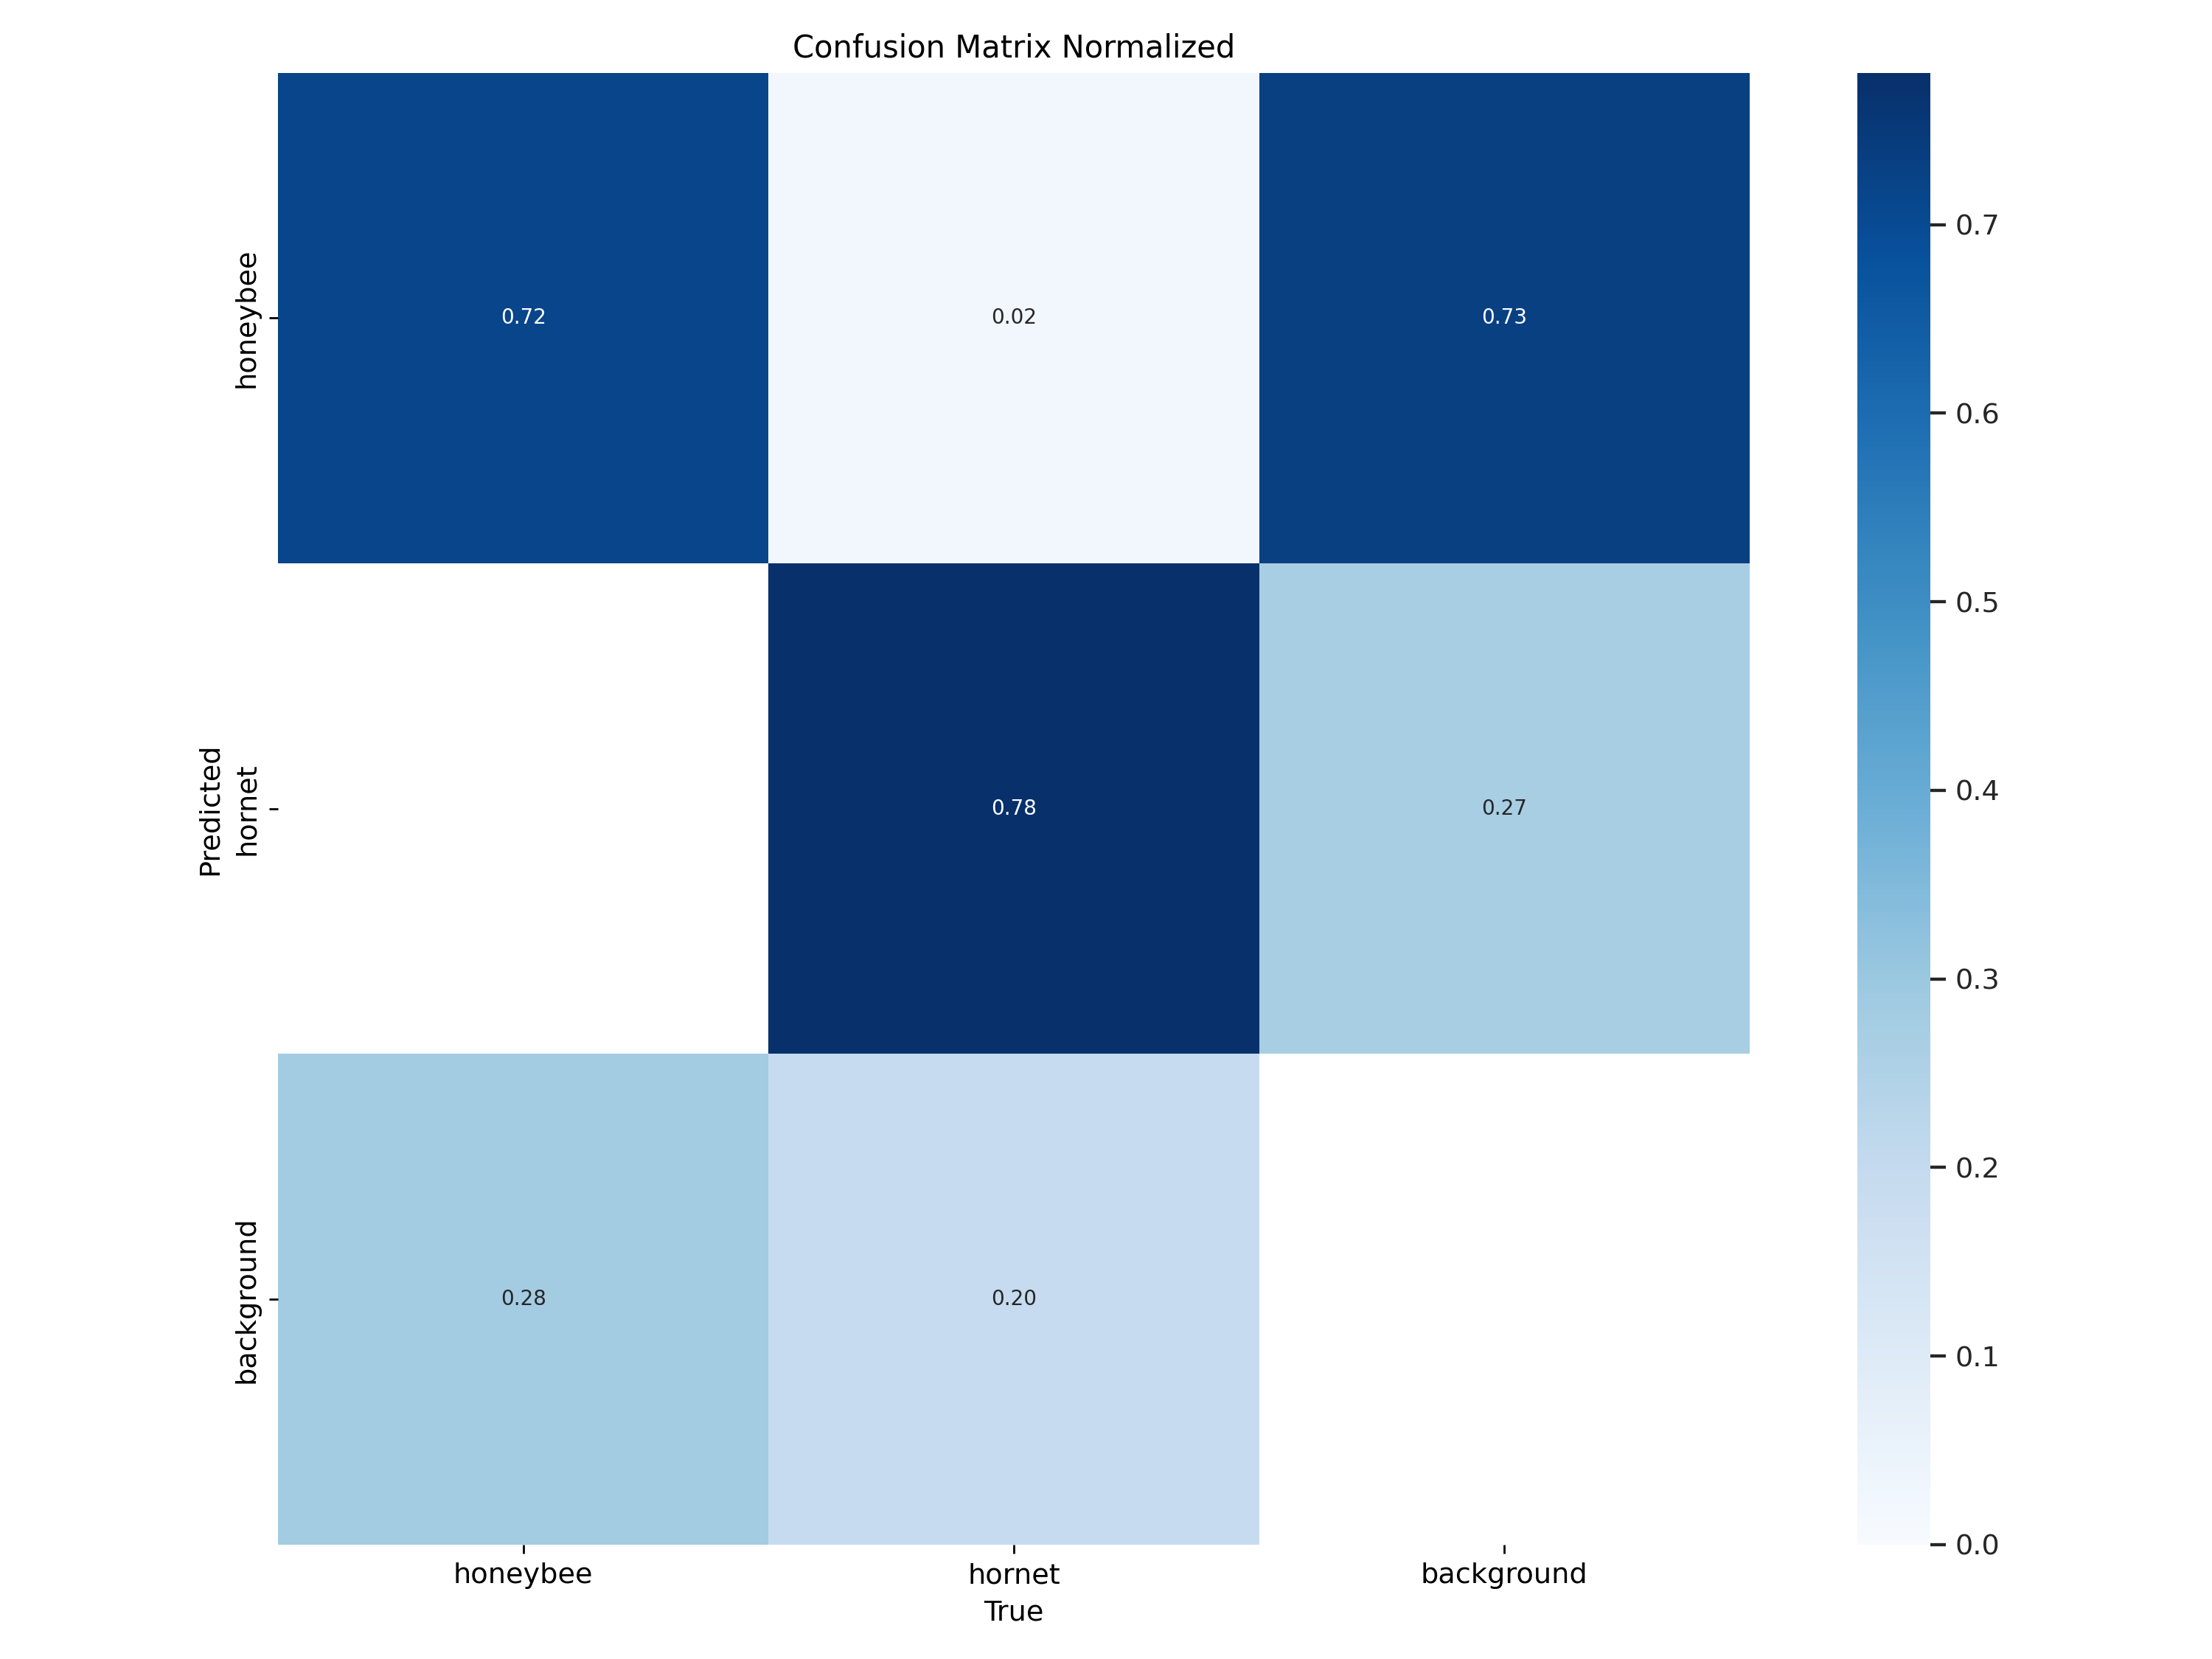

In [ ]:
# 테스트 데이터셋 결과를 혼동 행렬 이미지로 시각화
show_image(f"{project}/{test_name}/confusion_matrix_normalized.png", width=800, height=800)

# 7 . Inference

In [ ]:
from tqdm import tqdm
import glob

inference_name = "inference"
image_paths = glob.glob('Hornet-Detection-1/test/images/*jpg')
# 설정한 배치 크기
batch_size = 4

# 이미지 경로를 배치 크기에 맞춰 분할
inference_results = []
for i in tqdm(range(0, len(image_paths), batch_size)):
    batch_paths = image_paths[i:i + batch_size]
    results = model.predict(project=project,
                            source=batch_paths,
                            name=inference_name,
                            device='cuda',
                            imgsz=640,
                            save=True,
                            save_txt=True,
                            save_conf=True,
                            show_conf=False,
                            exist_ok=True)

    # 결과에서 원본 이미지 삭제하여 메모리 절약
    for item in results:
        del item.orig_img
    inference_results.append(results)
# 배치사이즈 만큼 묶여 있는 리스트를 풀어줌
inference_results = sum(inference_results,[])

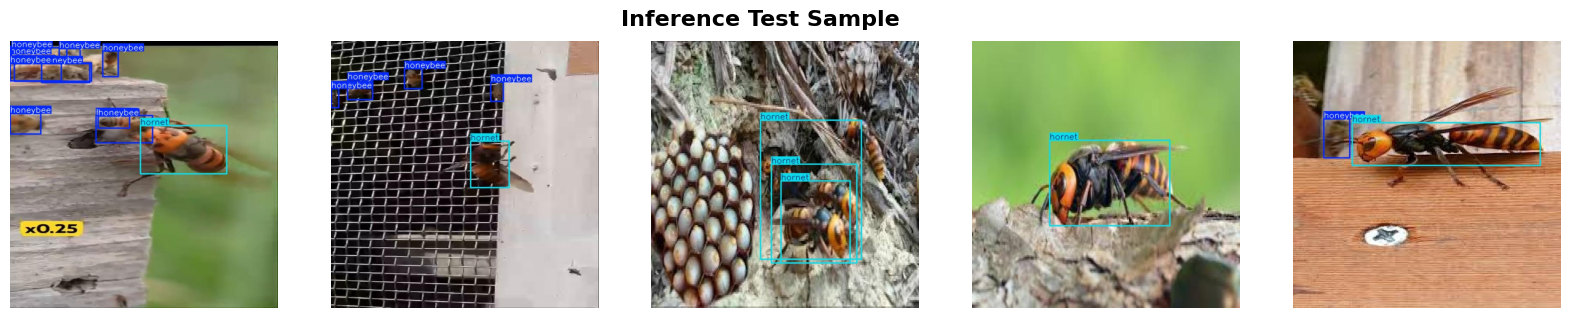

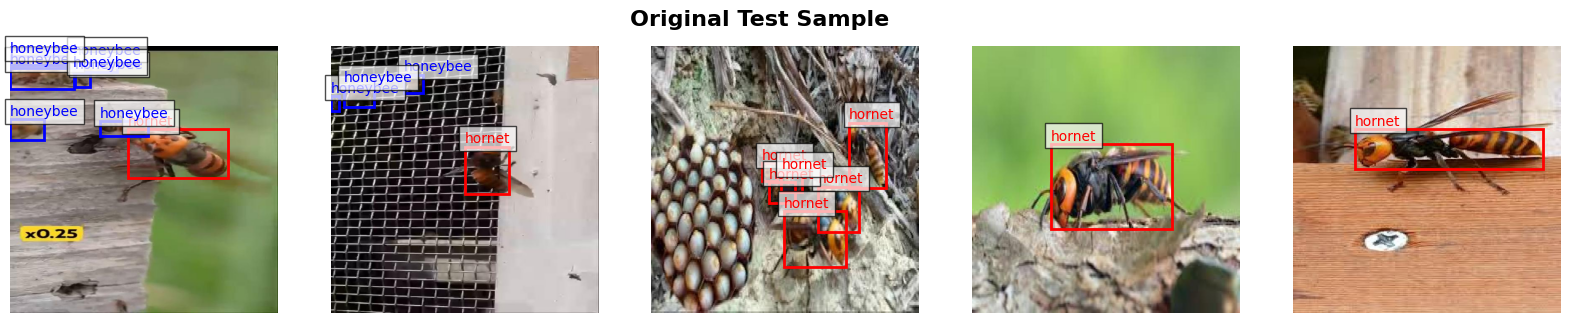

In [ ]:
import glob
import random
import matplotlib.pyplot as plt
import os

# YOLOv8 클래스 이름과 색상 설정
class_names = ['honeybee', 'hornet']  # 클래스 이름
class_colors = {'honeybee': 'blue', 'hornet': 'red'}  # 클래스별 색상

# 경로 설정
inference_paths = glob.glob(f'{project}/{inference_name}/*jpg')  # 추론 이미지 경로
test_image_base = 'Hornet-Detection-1/test/images'  # 테스트 이미지 기본 경로
test_label_base = 'Hornet-Detection-1/test/labels'  # 테스트 라벨 기본 경로

# 5개의 랜덤 이미지 경로 선택
random_paths = random.sample(inference_paths, 5)

# 공통 함수: 바운딩 박스 그리기
def draw_bounding_boxes(ax, img, label_file):
    """이미지에 바운딩 박스를 그리는 함수"""
    if os.path.exists(label_file):
        with open(label_file, 'r') as f:
            for line in f:
                # YOLOv8 라벨 파싱
                class_id, x_center, y_center, width, height = map(float, line.strip().split())
                class_name = class_names[int(class_id)]
                box_color = class_colors[class_name]

                # YOLO 형식 -> 픽셀 좌표 변환
                img_h, img_w = img.shape[:2]
                x_center *= img_w
                y_center *= img_h
                width *= img_w
                height *= img_h
                x1 = int(x_center - width / 2)
                y1 = int(y_center - height / 2)

                # 바운딩 박스 및 레이블 추가
                ax.add_patch(plt.Rectangle((x1, y1), width, height, edgecolor=box_color, facecolor='none', linewidth=2))
                ax.text(x1, y1 - 10, class_name, color=box_color, fontsize=10, bbox=dict(facecolor='white', alpha=0.7))

# (1) 추론 이미지 표시
fig, axes = plt.subplots(1, 5, figsize=(20, 5))  # 1행 5열
for ax, random_path in zip(axes, random_paths):
    image = plt.imread(random_path)
    ax.imshow(image)
    ax.axis('off')
fig.suptitle('Inference Test Sample', fontsize=16, fontweight='bold', y=0.81)
fig.subplots_adjust(top=0.85)  # 제목과 이미지 간 간격 조정
plt.show()

# (2) 테스트 이미지와 라벨 표시
fig, axes = plt.subplots(1, 5, figsize=(20, 10))  # 1행 5열
for ax, img_path in zip(axes, random_paths):
    # 경로 변경
    test_img_path = img_path.replace(f'{project}/{inference_name}', test_image_base)
    test_label_path = test_img_path.replace(".jpg", ".txt").replace("images", "labels")

    # 이미지 로드 및 표시
    img = plt.imread(test_img_path)
    ax.imshow(img)
    ax.axis('off')

    # 바운딩 박스 추가
    draw_bounding_boxes(ax, img, test_label_path)
fig.suptitle('Original Test Sample', fontsize=16, fontweight='bold', y=0.65)
fig.subplots_adjust(top=0.85)  # 제목과 이미지 간 간격 조정
plt.show()
